In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as k
from keras.layers import InputLayer
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
from keras.datasets import mnist
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.layers.core import Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import cv2
import pickle
import pandas as pd
from keras import applications
from sklearn.model_selection import train_test_split

############## Hyperparameters #############

learning_rate = 1e-5
weight_decay = 0.0005
lr_decay = 1e-6
lr_drop = 20
maxepochs = 25

################ Optimizers ###############

# optim = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=lr_decay, amsgrad=False)

#optim = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=lr_decay)

# optim = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

Using TensorFlow backend.


In [2]:
################ MNIST ######################
batch_size = 1028
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = np.append(x_train,x_test,axis=0)
y_train = np.append(y_train,y_test,axis=0)
print('x_train shape:', x_train.shape) #x_train shape: (60000, 28, 28, 1)
print('y_train shape:', y_train.shape) #y_train shape: (60000, 28, 28, 1)
num_category = 10
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

x_train shape: (70000, 28, 28, 1)
y_train shape: (70000,)


In [3]:
class CustomAugmentation(object):
    
    kernel = np.ones((3,3),np.uint8)
    
    def __init__(self, erosion = True, dilation = True):
        self.erosion = erosion
        self.dilation = dilation
    
    def __call__(self, img):
        
        randomNumber = np.random.random()
        
        #Erosion or dilation applied randomly
        
        if randomNumber < 0.9:
            pass
        elif randomNumber < 0.95:
            if self.erosion == True:
                img = cv2.erode(img,CustomAugmentation.kernel,iterations = 1)
                img = img.reshape(28,28,1)
        else:
            if self.dilation == True:
                img = cv2.dilate(img,CustomAugmentation.kernel,iterations = 1)
                img = img.reshape(28,28,1)
                
        return img

preprocessor = CustomAugmentation(erosion = False, dilation = True)

datagen = ImageDataGenerator(
    preprocessing_function = preprocessor,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zoom_range=0.1,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))

filepath = 'MNIST_Classifier-{epoch:02d}-{val_acc:.2f}.model'
# reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
earlystop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=0, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
cb_list = [reduce_lr, earlystop, checkpoint]

In [4]:

model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
__________

In [5]:

cnn = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  
                                steps_per_epoch=x_train.shape[0] // batch_size,
                                epochs=maxepochs,
                                validation_data=(x_test, y_test),callbacks=cb_list, verbose=1)


Epoch 1/25
68/68 [==============================] - 9s 130ms/step - loss: 0.8352 - acc: 0.7488 - val_loss: 0.1140 - val_acc: 0.9660
Epoch 2/25
68/68 [==============================] - 8s 120ms/step - loss: 0.1909 - acc: 0.9425 - val_loss: 0.0482 - val_acc: 0.9843
Epoch 3/25
68/68 [==============================] - 8s 120ms/step - loss: 0.1282 - acc: 0.9612 - val_loss: 0.0310 - val_acc: 0.9894
Epoch 4/25
68/68 [==============================] - 8s 121ms/step - loss: 0.1041 - acc: 0.9684 - val_loss: 0.0290 - val_acc: 0.9910
Epoch 5/25
68/68 [==============================] - 8s 119ms/step - loss: 0.0862 - acc: 0.9740 - val_loss: 0.0219 - val_acc: 0.9930
Epoch 6/25
68/68 [==============================] - 8s 120ms/step - loss: 0.0753 - acc: 0.9772 - val_loss: 0.0204 - val_acc: 0.9933
Epoch 7/25
68/68 [==============================] - 8s 120ms/step - loss: 0.0679 - acc: 0.9799 - val_loss: 0.0184 - val_acc: 0.9940
Epoch 8/25
68/68 [==============================] - 8s 122ms/step - loss: 0.

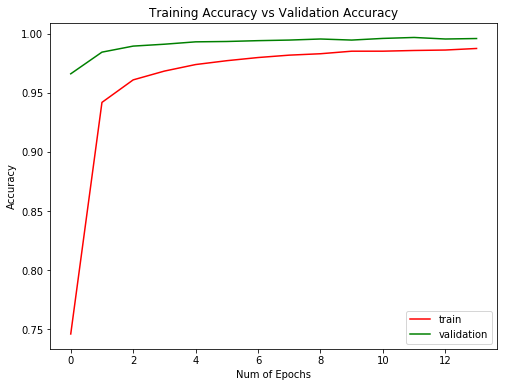

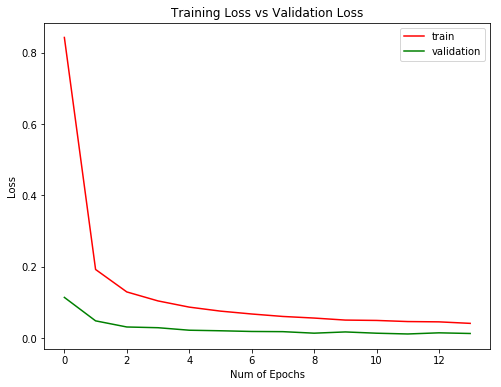

In [7]:
plt.figure(2)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 14, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(3)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 14, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

In [8]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Validation Accuracy: %.2f%%" % (scores[1]*100))

Training Accuracy: 99.50%
Validation Accuracy: 99.58%


In [ ]:
model.save('MNIST_Classifier-15-99.model')